<a href="https://colab.research.google.com/github/schahor/TU_25_SS_Data-Mining-und-Maschinelles-Lernen-2025/blob/main/09_Pytorch_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

# PyTorch Einführung

Machine-Learning Framework von Meta AI (Facebook), mittlerweile Teil der Linux Foundation. Kostenloses Open-Source Framework zum Training von Deep Learning Anwendungen.

Hilfreiche Ressourcen:
- [https://pytorch.org/](https://pytorch.org/)
- [Training a Classifier Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

## Vorgehensweise

1. Datensatz laden
2. Architektur des Neuronalen Netzes festlegen
3. Optimizerungsparameter festlegen
4. Training des Netzwerkes
5. Testen des trainierten Netzwerks

## 1. Datensatz laden

Für das Training verwenden wir hier den [Oxford Flowers 102](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/) Datensatz, der Bilder von 102 Blumenarten enthält. Ziel ist die Erstellung eines Bildklassifikator zur Vorhersage der Blumenart. Zunächst definieren wir notwendige Transformationen, um die Bilder für das Neuronale Netz aufzubereiten. Hierzu transformieren wir jedes Bild in einen Tensor zur Verarbeitung (3D-Datenmatrix) und reduzieren die Größe aller Bilder auf 64x64. Zusätzlich transformieren wir den Wertebereich der Bilder von \[0, 1\] in den Bereiche \[-1, 1\]. Um die Anzahl an Trainingsdaten künstlich zu erhöhen, sogenannte Dataset Augmentation, fügen wir beim Training zusätzlich zufälliges horizontales Spiegeln der Bilder hinzu.

In [ ]:
transform_train = T.Compose([T.ToTensor(), T.Resize((64, 64), antialias=True), T.RandomHorizontalFlip(p=0.5), T.Normalize(0.5, 0.5)])
transform_test = T.Compose([T.ToTensor(), T.Resize((64, 64), antialias=True), T.Normalize(0.5, 0.5)])

In [ ]:
# Flowers 102 Dataset
train_set = torchvision.datasets.Flowers102(root='data', split='train', transform=transform_train, download=True)
test_set = torchvision.datasets.Flowers102(root='data', split='test', transform=transform_test, download=True)

100%|██████████| 344862509/344862509 [00:29<00:00, 11556559.98it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 558498.84it/s]


100%|██████████| 14989/14989 [00:00<00:00, 14442550.58it/s]


In [ ]:
# Zeige das erste Trainingsbeispiel
print('Data Sample Shape: ', train_set[0][0].shape, 'Label: ', train_set[0][1])

Data Sample Shape:  torch.Size([3, 64, 64]) Label:  0


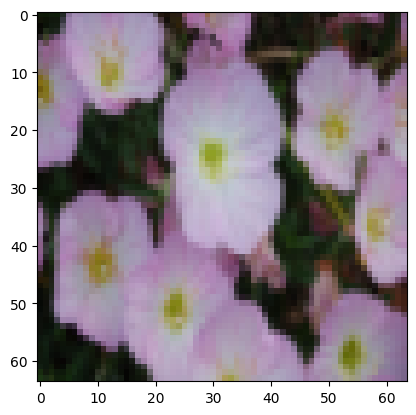

In [ ]:
# Anmerkung: PyTorch representiert die Channels eines Bildes (3 bei RGB Inputs) in der Dimension vor der Höhe und Breite (hier 64x64)
plt.imshow(train_set[0][0].permute(1,2,0) * 0.5 + 0.5)

## 2. Architektur des Neuroaneln Netzes festlegen

An dieser Stelle existieren zwei Möglichkeiten: entweder wir definieren eine eigene Architektur oder wir verwenden eine vordefinierte Architektur. Beginnen wir zunächst mit einer eigenen Architektur mit 4 Convolutional Layers, einem Pooling Layer und einem Fully-Connected Layer zur Klassifikation.


In [ ]:
custom_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=128, out_features=102)
)

Als Alternative nehmen wir eine vordefinierte Architektur, in diesem Fall ein [ResNet-18](https://en.wikipedia.org/wiki/Residual_neural_network). Zusätzlich verwenden wir zur Initialisierung vortrainierte Gewichte. Da das Modell auf einem Datensatz mit 1000 Klassen vortrainiert wurde, müssen wir den letzten Layer zur Klassifikation anpassen bzw. ersetzen.

In [ ]:
resnet18_model = torchvision.models.resnet.resnet18(pretrained=True)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 102)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 308MB/s]


## 3. Optimizerungsparameter festlegen

Für das Training müssen folgende Parameter festgelegt werden:
- Batch Size: Wie viele Bilder werden für jeden Optimierungsschritt verwendet?
- Epochs: Wie viele Iterationen über die Trainingsdaten werden durchgeführt?
- Learning Rate: Mit welcher Lernrate werden die Modellparameter aktualisiert?
- Optimizer: Wie wird optimiert und welche Modellparameter werden optimiert?
- Loss Function: Wie sieht unsere Optimierungsfunktion aus?

In [ ]:
batch_size=64
epochs=3
learning_rate=0.1
optimizer = torch.optim.SGD(params=custom_model.parameters(), lr=learning_rate, momentum=0.9)
loss_fkt = nn.CrossEntropyLoss()

In [ ]:
# Dataloader helfen uns über die Datensets zu iterieren
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

## 4. Training des Custom Netzwerkes
Entsprechend dem Vorgehen in der Vorlesung/Übung werden iterativ Trainingsbeispiele gesampled, diese in das Modell gegeben und basierend auf dem Fehler der Vorhersage die Gewichte des Netzes aktualisiert. Zunächst muss das Modell in den Trainingsmodus versetzt werden (wichtig für "Spezial"-Layer) und sollte auf die GPU verschoben werden, um das Training zu beschleunigen.

Hinweis: Laufzeitumgebung mit verfügbarer GPU wird benötigt.

In [ ]:
custom_model.cuda()
custom_model.train()
for epoch in range(epochs):
  running_loss = 0.0
  for x, y in train_loader:
    # Verschiebe Batch auf GPU
    x, y = x.cuda(), y.cuda()

    # Lösche vorherige Gradienten der Parameter
    optimizer.zero_grad()

    # Führe Forward Pass durch
    outputs = custom_model(x)

    # Berechne Loss
    loss = loss_fkt(outputs, y)

    # Berechne Gradienten
    loss.backward()

    # Update Modellparameter
    optimizer.step()

    # Aktualisiere Running Loss
    running_loss += loss.cpu().item() * len(x)

  # Gebe den aktuellen Loss auf der Konsole aus
  print(f'Epoch {epoch} \t Loss {running_loss / len(train_set):.4f}')

Epoch 0 	 Loss 4.6285
Epoch 1 	 Loss 4.5636
Epoch 2 	 Loss 4.4272


## 5. Testen des trainierten Netzwerks
Um zu überprüfen, wie gut unser Modell generalisiert hat, testen wir die Performance auf den ungesehenen Testdaten. Hierzu setzen wir das Modell in den Evaluationsmodus und verhindern zugleich die Berechnung von Gradienten, um den GPU Speicher zu schonen und die Inferenz zu beschleunigen.

In [ ]:
custom_model.cuda()
custom_model.eval()

num_correct_predictions = 0
num_total_predictions = 0

for x, y in test_loader:
  with torch.no_grad():
    # Verschiebe Batch auf GPU
    x, y = x.cuda(), y.cuda()

    # Führe Forward Pass durch
    outputs = custom_model(x)

    # Berechne Vorhersagen
    y_pred = outputs.argmax(dim=1)

    # Zähle korrekte Vorhersagen
    num_correct_predictions += (y_pred == y).sum()
    num_total_predictions += len(y)

print(f'{num_correct_predictions} von {num_total_predictions} Testsamples korrekt vorhergesagt')
print(f'Dies entspricht einer Accuracy von {num_correct_predictions/num_total_predictions:.4f}')
print(f'Random Guessing würde einer Accuracy von {1/102:.4f} entsprechen')

{num_correct_predictions} von {num_total_predictions} Testsamples korrekt vorhergesagt
Dies entspricht einer Accuracy von 0.0185
Random Guessing würde einer Accuracy von 0.0098 entsprechen


## Wiederholung Schritte 3-5 mit ResNet-18

Anpassung des Optimizers notwendig. Alle anderen Parameter lassen wir in diesem Fall unverändert.

In [ ]:
learning_rate = 0.1
optimizer = torch.optim.SGD(params=resnet18_model.parameters(), lr=learning_rate)

In [ ]:
resnet18_model.cuda()
resnet18_model.train()
for epoch in range(epochs):
  running_loss = 0.0
  for x, y in train_loader:
    # Verschiebe Batch auf GPU
    x, y = x.cuda(), y.cuda()

    # Lösche vorherige Gradienten der Parameter
    optimizer.zero_grad()

    # Führe Forward Pass durch
    outputs = resnet18_model(x)

    # Berechne Loss
    loss = loss_fkt(outputs, y)

    # Berechne Gradienten
    loss.backward()

    # Update Modellparameter
    optimizer.step()

    # Aktualisiere Running Loss
    running_loss += loss.cpu().item() * len(x)

  # Gebe den aktuellen Loss auf der Konsole aus
  print(f'Epoch {epoch} \t Loss {running_loss / len(train_set):.4f}')

Epoch 0 	 Loss 4.3150
Epoch 1 	 Loss 2.1053
Epoch 2 	 Loss 0.9530


In [ ]:
resnet18_model.cuda()
resnet18_model.eval()

num_correct_predictions = 0
num_total_predictions = 0

for x, y in test_loader:
  with torch.no_grad():
    # Verschiebe Batch auf GPU
    x, y = x.cuda(), y.cuda()

    # Führe Forward Pass durch
    outputs = resnet18_model(x)

    # Berechne Vorhersagen
    y_pred = outputs.argmax(dim=1)

    # Zähle korrekte Vorhersagen
    num_correct_predictions += (y_pred == y).sum()
    num_total_predictions += len(y)

print(f'{num_correct_predictions} von {num_total_predictions} Testsamples korrekt vorhergesagt')
print(f'Dies entspricht einer Accuracy von {num_correct_predictions/num_total_predictions:.4f}')
print(f'Random Guessing würde einer Accuracy von {1/102:.4f} entsprechen')

{num_correct_predictions} von {num_total_predictions} Testsamples korrekt vorhergesagt
Dies entspricht einer Accuracy von 0.4085
Random Guessing würde einer Accuracy von 0.0098 entsprechen
